**Oreum Industries Internal Project, 2024Q1**

---

# 100_ModelA0.ipynb

### Oreum Copula Demo in `oreum_copula`

Implementation of Bayesian Copula-Based Expected Loss Cost Forecasting. 
We use highly advanced Bayesian inference techniques and a Bayesian workflow, 
specifically using the `pymc` & `arviz` ecosystem.

Here we demonstrate an E2E workflow for novel models of increasing sophistication.
We evaluate the behaviour and performance of the models throughout the workflows,
including several state-of-the-art methods unavailable to conventional
max-likelihood / machine-learning models.

**In this Notebook:**

+ Build & evaluate `ModelA0`, a naive version of the core project architecture **without a copula**
+ Demonstrate some of the core aspects and make the case for needing a copula


## Contents

+ [Setup](#Setup)

+ [0. Synthesize Dataset](#0.-Synthesize-Dataset)

+ [1. Model Description](#1.-Model-Description)

+ [2. Custom Bayesian Model `ModelA0`](#2.-Custom-Bayesian-Model-`ModelA0`)

---

# Setup

## Imports

In [1]:
import sys
from copy import deepcopy
from pathlib import Path

import arviz as az
import numpy as np
import pandas as pd
from oreum_core import eda
from oreum_core import model_pymc as mt
from pyprojroot.here import here

# prepend local project src files
module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))    # sys.path.append(str(module_path))

# autoreload local modules to allow dev-js
%load_ext autoreload
%autoreload 2
import warnings  # noqa

from engine import logger, utils  #.trainer import Trainer
from model import copula
from synthetic.create_copula import CopulaBuilder

warnings.simplefilter(action='ignore', category=FutureWarning)  # noqa
import seaborn as sns  # warning suppression: it's far too chatty  # noqa

/Users/jon/miniforge/envs/oreum_copula/lib/python3.12/site-packages/pymc/util.py:40: FutureWarning: dataset_to_point_list has been moved to backends.arviz. Importing from util will fail in a future release.
  warnings.warn(


##### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='darkgrid', palette='muted', context='notebook', 
        rc={'savefig.dpi':300, 'figure.figsize': (12, 3)})

log = logger.get_logger('100_ModelA0', notebook=True)
_ = logger.get_logger('oreum_core', notebook=True)

## Local Functions and Global Vars

In [3]:
RSD = 42
RNG = np.random.default_rng(seed=RSD)

## Data Connections and Helper Objects

In [4]:
figio = eda.FigureIO(here(Path('plots')).resolve(strict=True))
mdlio = mt.PYMCIO(here(Path('data', 'models')).resolve(strict=True))

---

---

# 0. Load Dataset

## 0.1 Synthetise Demo Dataset for Project

See `000_Intro.ipynb` for details

In [5]:
cb = CopulaBuilder()
df_all = cb.create(nobs=60)
print(cb.ref_vals)
eda.display_ht(df_all)

{'c_r': -0.7, 'c_cov': array([[ 1. , -0.7],
       [-0.7,  1. ]]), 'm0_kind': 'lognorm', 'm1_kind': 'lognorm', 'm0_params': {'mu': 0.2, 'sigma': 0.5}, 'm1_params': {'mu': 2.0, 'sigma': 1.0}}


,c0,c1,u0,u1,m0,m1,c0x,c1x,u0x,u1x,m0x,m1x
oid,,,,,,,,,,,,
i000,-0.68,-0.12,0.25,0.45,0.87,6.54,0.50,-0.14,0.69,0.45,1.57,6.43
i001,-0.33,1.06,0.37,0.85,1.04,21.25,0.65,1.52,0.74,0.94,1.69,33.89
i002,1.29,-2.30,0.90,0.01,2.33,0.74,-0.23,-0.23,0.41,0.41,1.09,5.85
i057,-0.27,-0.14,0.39,0.44,1.07,6.43,-0.19,0.30,0.42,0.62,1.11,9.99
i058,-0.21,0.22,0.42,0.59,1.10,9.23,-0.03,-1.17,0.49,0.12,1.20,2.30
i059,-1.57,1.38,0.06,0.92,0.56,29.49,1.14,0.75,0.87,0.77,2.16,15.67


'Shape: (60, 12), Memsize 0.0 MB'

In [6]:
perm = RNG.permutation(df_all.index.values)
df_train = df_all.loc[perm[:50]].sort_index()
df_holdout = df_all.loc[perm[50:]].sort_index()
# eda.describe(df_train, nobs=3, get_counts=False)
eda.display_ht(df_train)

,c0,c1,u0,u1,m0,m1,c0x,c1x,u0x,u1x,m0x,m1x
oid,,,,,,,,,,,,
i000,-0.68,-1.22e-01,0.25,0.45,0.87,6.54,0.50,-0.14,0.69,0.45,1.57,6.43
i003,-0.24,-4.62e-03,0.41,0.50,1.08,7.36,1.58,0.77,0.94,0.78,2.69,15.92
i004,-0.31,-3.46e-01,0.38,0.36,1.04,5.23,-0.47,0.54,0.32,0.71,0.97,12.71
i056,-0.01,-1.11e+00,0.50,0.13,1.21,2.44,0.06,2.46,0.52,0.99,1.26,86.77
i057,-0.27,-1.39e-01,0.39,0.44,1.07,6.43,-0.19,0.30,0.42,0.62,1.11,9.99
i059,-1.57,1.38e+00,0.06,0.92,0.56,29.49,1.14,0.75,0.87,0.77,2.16,15.67


'Shape: (50, 12), Memsize 0.0 MB'

## 0.2 Quick EDA to remind how the data looks

### 0.2.1 Jointplot marginals $M_{0}$, $M_{1}$

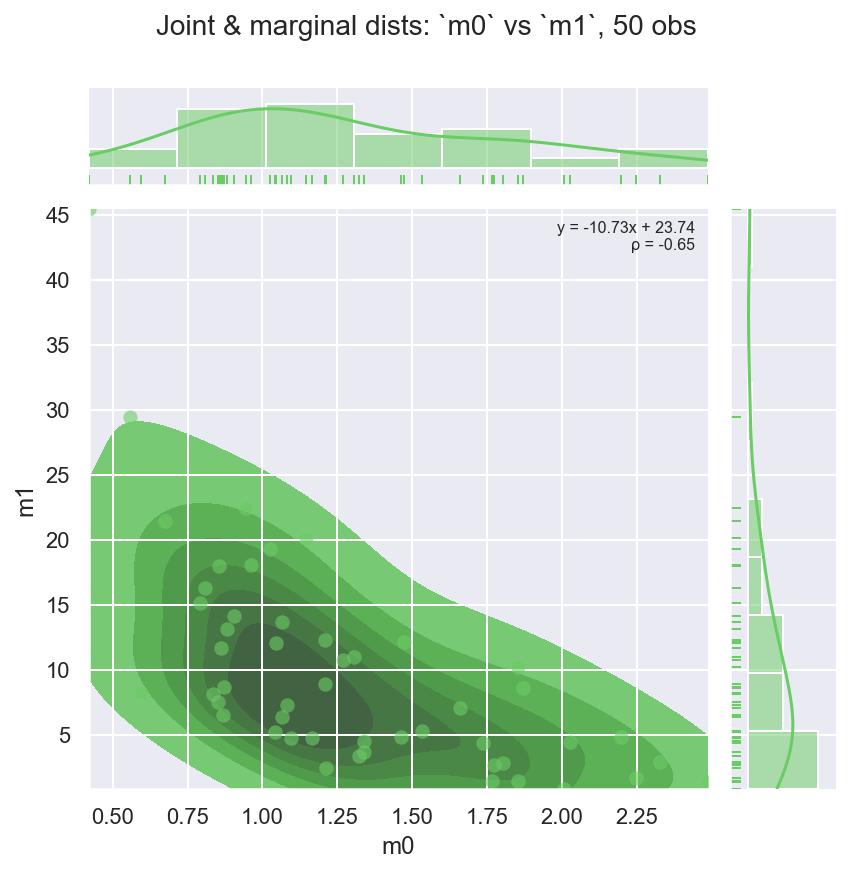

In [7]:
f = eda.plot_joint_numeric(data=df_train, ft0='m0', ft1='m1', kind='kde+scatter', colori=2, 
            subtitle='Observed Marginals with Copula Correlation')

**Observe:**

+ Note the negative correlation $\rho \approx -0.65$ and the skewed marginals with different scales

### 0.2.2 Plot product $y = M_{0} * M_{1}$ to motivate the correct estimation of copula

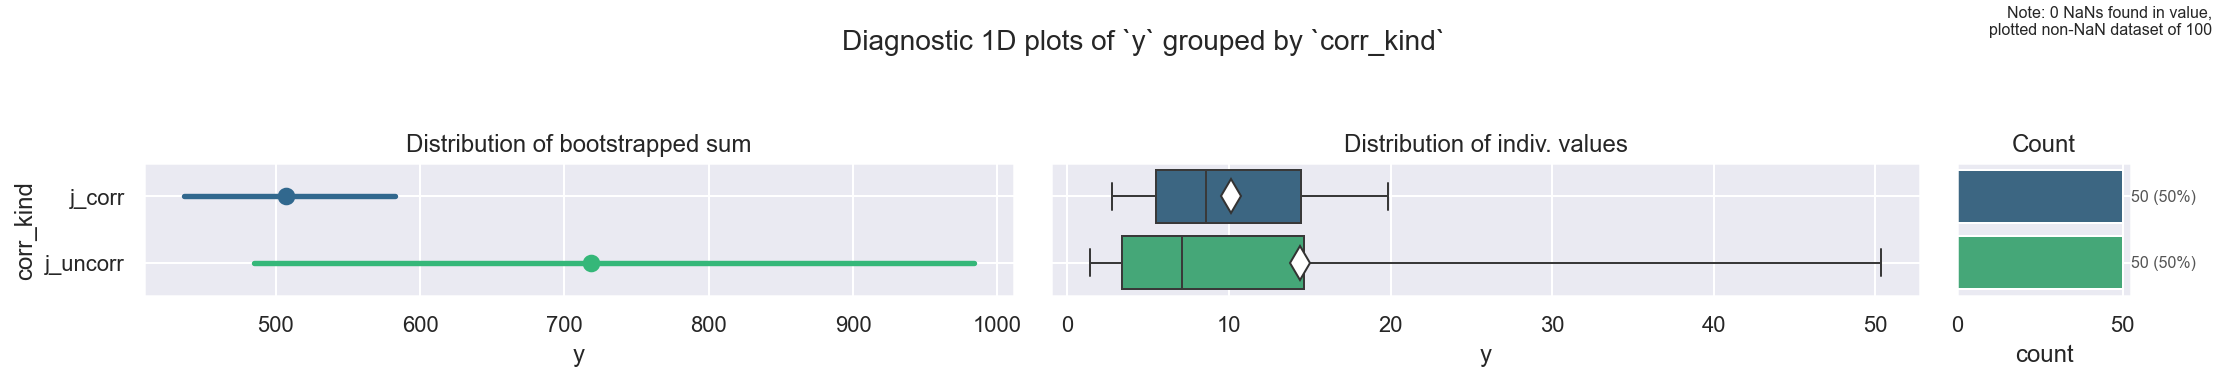

In [8]:
dfp = pd.concat((df_train[['m0', 'm1']], df_train[['m0x', 'm1x']]\
                 .rename(columns={'m0x':'m0', 'm1x': 'm1'})),
                axis=0, ignore_index=True)
dfp['corr_kind'] = np.repeat(['j_corr', 'j_uncorr'], repeats=len(df_train))
dfp['y'] = dfp[['m0', 'm1']].product(axis=1)
pal = sns.color_palette(['C2', 'C3'])
f = eda.plot_smrystat_grp(dfp, grp='corr_kind', val='y', palette=pal, plot_outliers=False)

**Observe:**

+ The (bootstrapped) sum of `j_uncorr` ($\mu \approx 700$) is almost always much higher than for `j_corr` ($\mu \approx 500$)
+ This shows that even if we estimated each marginal correctly, if our model were to (erroroneously) ignore the coupled covariance between our marginals `m0`, `m1`, we would (erroneously) overestimate the joint distribution total value

---

---

# 1. Model Description

In `ModelA0` we demonstrate a very naive way to estimate the marginals: as **independent distributions without a copula**.

Interestingly, because we sample the marginals simultaneously within a single model, this is still massively better than
estimating two completely separate models (one per marginal) as is often done in simple Frequentist modelling.

## 1.1 Estimate Marginals

We have two marginals $M_{0}$ and $M_{1}$, which we estimate as both being $\text{LogNormal}$ distributions (because we
want to keep this example simple):

$$
\begin{aligned}
M_{0}\\
\beta_{M_{0}}^{j0} &\sim \text{Normal}(\mu, \sigma) \\
\sigma_{M_{0}} &\sim \text{InverseGamma}(\alpha, \beta) \\
\mathcal{L}\ \hat{M_{0}} &\sim \text{LogNormal}(\beta_{M_{0}}^{T}\mathbf{x}_{i}^{j0}, \sigma_{M_{0}}) \\
\\
M_{1}\\
\beta_{M_{1}}^{j1} &\sim \text{Normal}(\mu, \sigma) \\
\sigma_{M_{1}} &\sim \text{InverseGamma}(\alpha, \beta) \\
\mathcal{L}\ \hat{M_{1}} &\sim \text{LogNormal}(\beta_{M_{1}}^{T}\mathbf{x}_{i}^{j1}, \sigma_{M_{1}}) \\
\end{aligned}
$$

where:

+ We treat marginal $M_{0}$ and $M_{1}$ separately, although both are estimated as a $\text{LogNormal}$
+ Observations $\mathbf{x}_{i}$ have features $j$, and we define simple linear coefficients $\beta_{M_{0}}^{j0}$
+ Note in this example synthetic dataset we dont have any features, so we just set an intercept and retain the formality
  of the structure for general later usage
+ The linear sub-models e.g. $\beta_{M_{0}}^{T}\mathbf{x}^{j0}$ let us regress onto (potentially independent) subsets 
  of features $j0$ and $j1$


---

---

# 2. Custom Bayesian Model `ModelA0`

This is the first of many Bayesian models that we will create in this project. Refer to `000_Intro.ipynb` $\S \text{Preamble}$
for the myriad reasons this is a better general method to use.

## 2.0 Prepare & Transform Dataset for Linear Model

This is a preparatory step to transform the observational data into a form for
use in the custom Bayesian models. We will use the transformed datasets `dfx_*` 
in all subsequent models where possible.

NOTE:

+ For this example Notebook we _will_ partition into `train` & `holdout` sets
  (see `README.md ## 5. Data Standards` for terminology)
+ We will (as usual) evaluate in-sample using Pareto-smoothed Leave-One-Out (LOO-PIT) cross-validation testing
+ We will also evaluate out-of-sample (because we have the ground truth) to demonstrate model behaviour
+ This means we still follow our standard process for preparation, transformation, standardization for `dfa` and `dfb`
+ Our model architecture wants two dataframes `obs_m0` and `obs_m1`, one per marginal - and we will make these based on arg `kind`
+ We have no features for `m0` and `m1`, so the linear sub-models have to be intercept-only. 
+ Here we must also forget anything we know about the construction of the synthetic data, this is all we have.

### Fit and transform `train` set

In [9]:
dfx_creator_m0 = utils.ProjectDFXCreator(kind='m0')
dfx_m0_train = dfx_creator_m0.get_dfx(df_train)
eda.describe(dfx_m0_train)

dfx_creator_m1 = utils.ProjectDFXCreator(kind='m1')
dfx_m1_train = dfx_creator_m1.get_dfx(df_train)
eda.describe(dfx_m1_train)

,32,4,37,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: oid,i040,i006,i046,object,0,NaN,NaN,50,i000,1,NaN,NaN,NaN,i000,NaN,NaN,NaN,i059
m0,0.87,1.47,1.46,float64,0,0.0,0.0,NaN,NaN,NaN,64.71,1.29,0.5,0.42,0.89,1.19,1.72,2.49
intercept,1.0,1.0,1.0,float64,0,0.0,0.0,NaN,NaN,NaN,50.00,1.0,0.0,1.0,1.0,1.0,1.0,1.0


'Shape: (50, 3), Memsize 0.0 MB'

,4,34,41,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: oid,i006,i042,i050,object,0,NaN,NaN,50,i000,1,NaN,NaN,NaN,i000,NaN,NaN,NaN,i059
m1,12.15,2.96,8.62,float64,0,0.0,0.0,NaN,NaN,NaN,493.0,9.86,8.25,0.89,4.47,7.84,12.93,45.47
intercept,1.0,1.0,1.0,float64,0,0.0,0.0,NaN,NaN,NaN,50.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


'Shape: (50, 3), Memsize 0.0 MB'

### Transform `holdout` set

In [10]:
dfx_m0_holdout = dfx_creator_m0.get_dfx(df_holdout, in_sample=False)
eda.describe(dfx_m0_holdout)

dfx_m1_holdout = dfx_creator_m1.get_dfx(df_holdout, in_sample=False)
eda.describe(dfx_m1_holdout)

,4,8,7,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: oid,i013,i043,i036,object,0,NaN,NaN,10,i001,1,NaN,NaN,NaN,i001,NaN,NaN,NaN,i058
m0,1.03,1.52,2.05,float64,0,0.0,0.0,NaN,NaN,NaN,13.73,1.37,0.48,0.86,1.05,1.21,1.49,2.33
intercept,1.0,1.0,1.0,float64,0,0.0,0.0,NaN,NaN,NaN,10.00,1.0,0.0,1.0,1.0,1.0,1.0,1.0


'Shape: (10, 3), Memsize 0.0 MB'

,4,6,1,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: oid,i013,i033,i002,object,0,NaN,NaN,10,i001,1,NaN,NaN,NaN,i001,NaN,NaN,NaN,i058
m1,13.91,4.48,0.74,float64,0,0.0,0.0,NaN,NaN,NaN,82.54,8.25,6.15,0.74,4.38,5.99,11.89,21.25
intercept,1.0,1.0,1.0,float64,0,0.0,0.0,NaN,NaN,NaN,10.00,1.0,0.0,1.0,1.0,1.0,1.0,1.0


'Shape: (10, 3), Memsize 0.0 MB'

---

## 2.1 Build Model Object

`ModelA0` model imported from `src.model.copula.py` where it is fully defined

In [11]:
mdla0 = copula.ModelA0(obs_m0=dfx_m0_train, obs_m1=dfx_m1_train, obs_nm='dfx_train',
                dfx_creatord={'m0':dfx_creator_m0, 'm1':dfx_creator_m1})
mdla0.build()
utils.display_rvs(mdla0)
mdla0.debug()


'RVs for mdla0_v1.3.0_dfx_train'

beta_m0 ~ Normal(0, 1)

beta_m1 ~ Normal(0, 1)

sigma ~ InverseGamma(5, 4)

yhat ~ Deterministic(f(mhat))

point={'beta_m0': array([0.]), 'beta_m1': array([0.]), 'sigma_log__': array([0., 0.])}

No problems found
point={'beta_m0': array([0.]), 'beta_m1': array([0.]), 'sigma_log__': array([0., 0.])}

No problems found


'Ran 3 checks: [test: assert_no_rvs(logp), debug: random, debug: logp]'

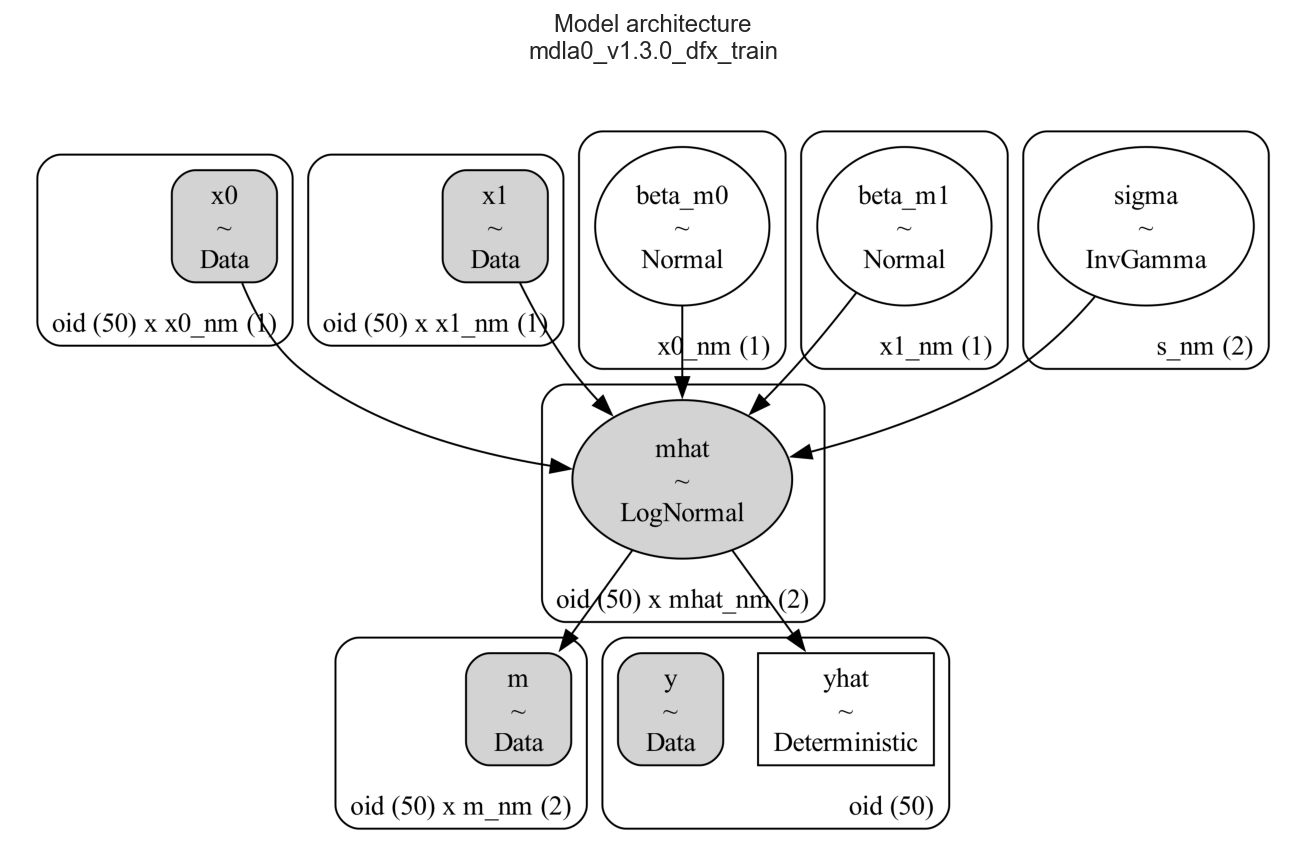

In [12]:
fqn = mdlio.write_graph(mdla0)
figio.read(fqn=fqn, title=f'Model architecture\n{mdla0.mdl_id}', figsize=(12, 6))

---

## 2.2 Sample Prior Predictive, View Diagnostics

In [13]:
mdla0.sample_prior_predictive(var_names=mdla0.rvs_marg + mdla0.rvs_ppc, replace=True)

### 2.2.1 Evaluate Prior PPC

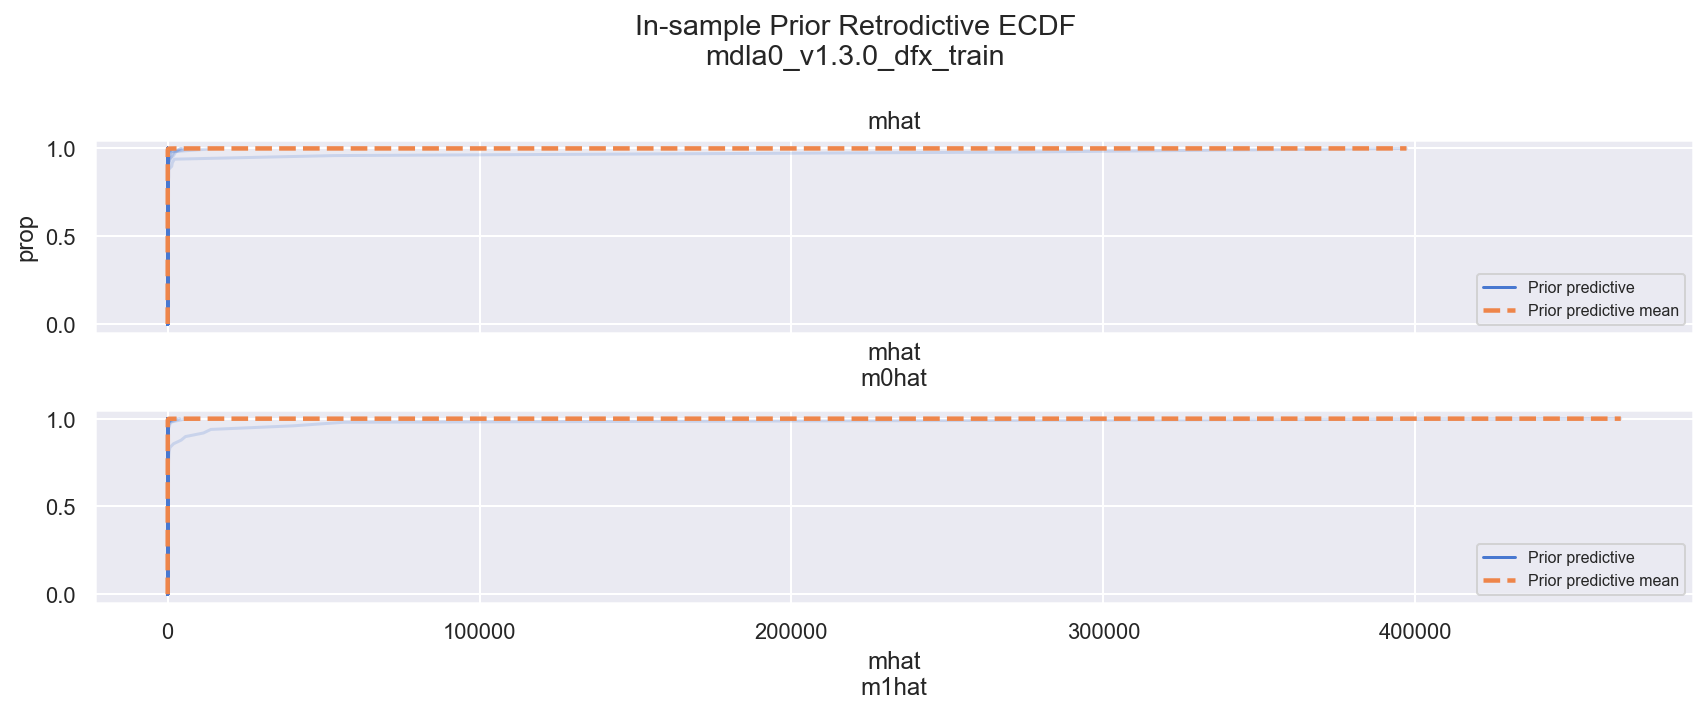

In [14]:
GRP = 'prior'
f = mt.plot_ppc(mdl=mdla0, group=GRP, var_names=mdla0.rvs_ppc, flatten=['oid'])

**Observe:**

+ Terrible fit as expected, but the range is valid

### 2.2.2 Evaluate priors and hyperpriors on linear submodels

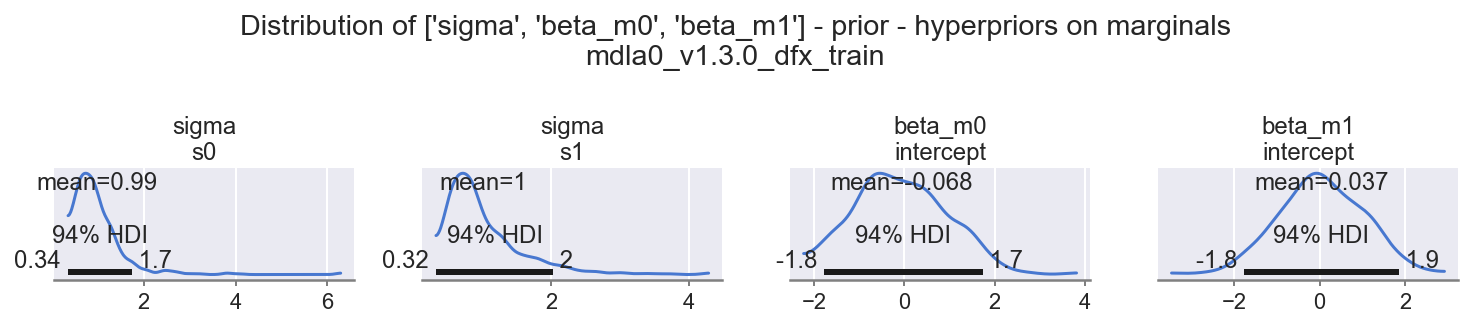

In [15]:
f = mt.facetplot_krushke(mdl=mdla0, group=GRP, txtadd='hyperpriors on marginals',
        rvs=mdla0.rvs_marg, m=4, rvs_hack=1)

**Observe:**

+ Priors seem reasonable

### ~~2.2.3 Evaluate priors on copula structure~~

No copula in this naive model

---

## 2.3 Sample Posterior, View Diagnostics

In [16]:
mdla0.sample(progressbar=True)
mdla0.sample_posterior_predictive(store_ppc=True, insamp=True, var_names=mdla0.rvs_ppc + mdla0.rvs_det)
mdlio.write_idata(mdl=mdla0)

Output()

Output()

PosixPath('/Users/jon/workspace/oreum/oreum_copula/data/models/idata_mdla0_v130_dfx_train.netcdf')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[s0],0.421,0.044,0.343,0.509,0.001,0.001,3112.0,1466.0,1.0
sigma[s1],0.868,0.086,0.714,1.036,0.002,0.001,2866.0,1590.0,1.0
beta_m0[intercept],0.182,0.060,0.070,0.286,0.001,0.001,3027.0,1727.0,1.0
beta_m1[intercept],1.933,0.116,1.722,2.145,0.002,0.002,2529.0,1682.0,1.0


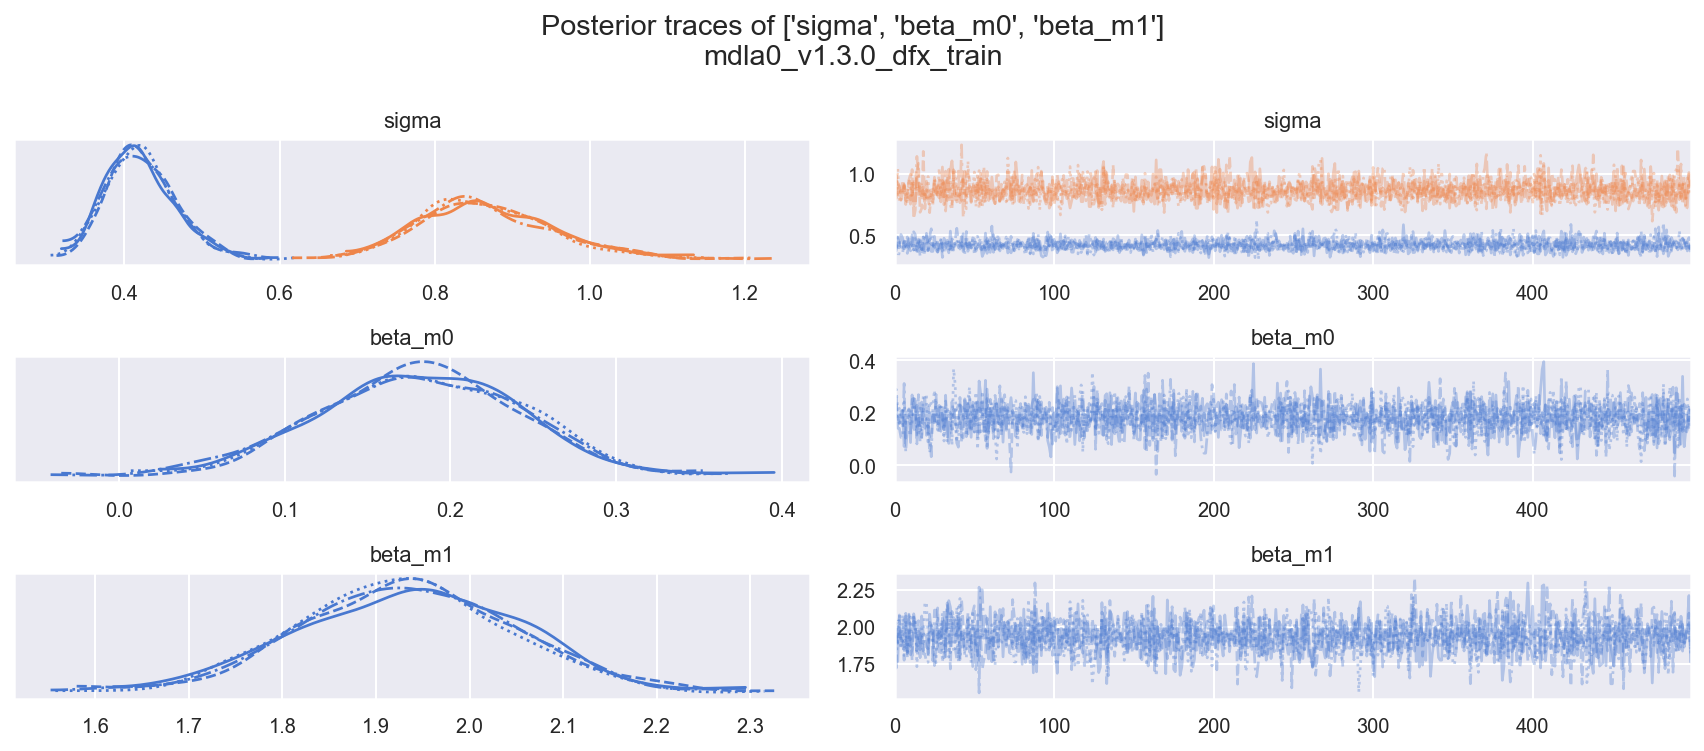

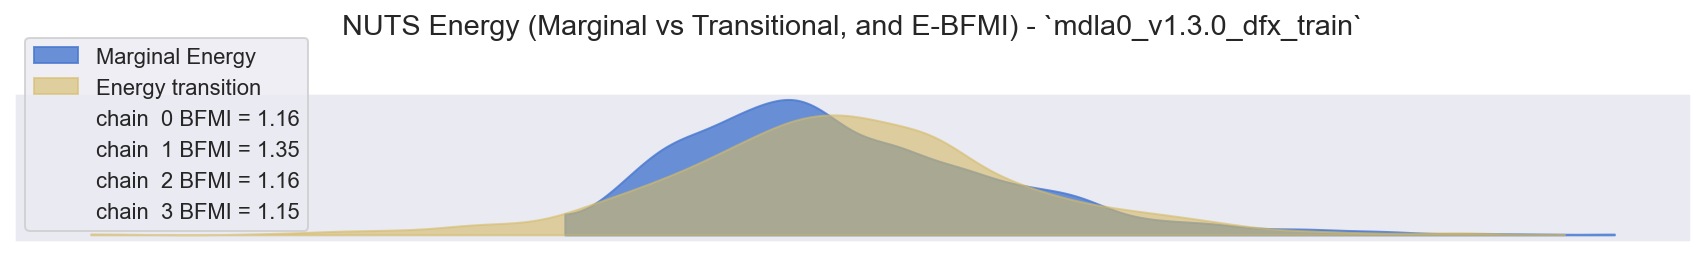

In [17]:
f = mt.plot_trace(mdl=mdla0, rvs=mdla0.rvs_marg, kind='trace')
f = mt.plot_energy(mdl=mdla0)
smry = mt.get_summary(mdl=mdla0, rvs=mdla0.rvs_marg)
smry

**Observe:**

+ Posterior distributions reasonably smooth and central
+ Samples well-mixed and well-behaved: `ess_bulk` is good, `r_hat` is good
+ Marginal energy | energy transition looks okay: `E-BFMI > 0.3` so [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi)

---

## 2.4 Evaluate Posterior PPC (In-Sample)

### 2.4.1 ECDF plots: univariate marginals $M_{0}$, $M_{1}$

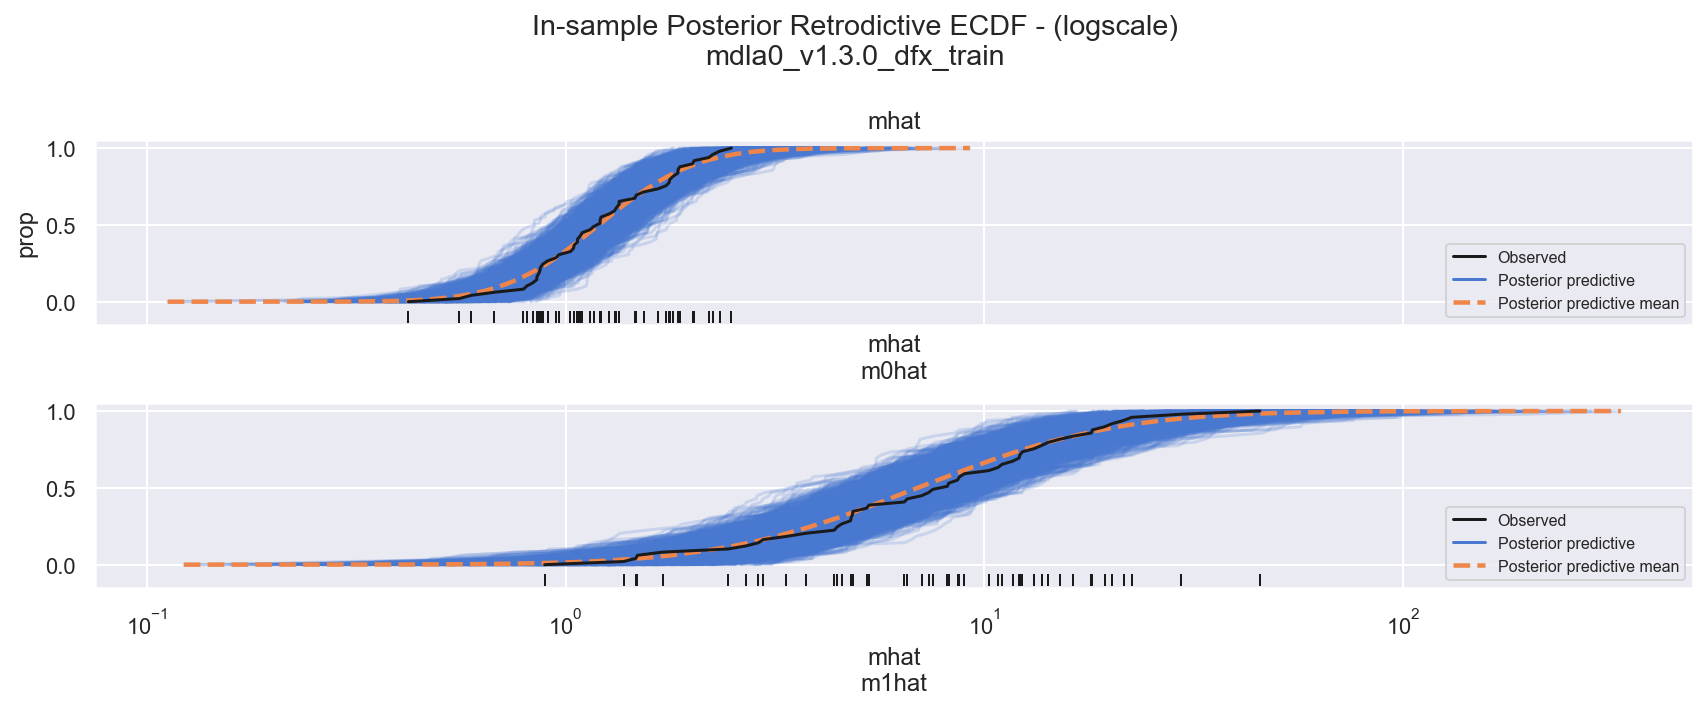

In [18]:
GRP = 'posterior'
f = mt.plot_ppc(mdl=mdla0, group=GRP, var_names=mdla0.rvs_ppc, logx=True, flatten=['oid'], observed_rug=True)

**Observe:**

+ `m0`: bulk has good fit, tails also good, but a little heavy
+ `m1`: bulk has good fit, tails okay but a little heavy

> Does this mean we have a good fit? We need to look at the resulting yhat and the covariance...

### 2.4.2 ECDF plot $\hat{y}$

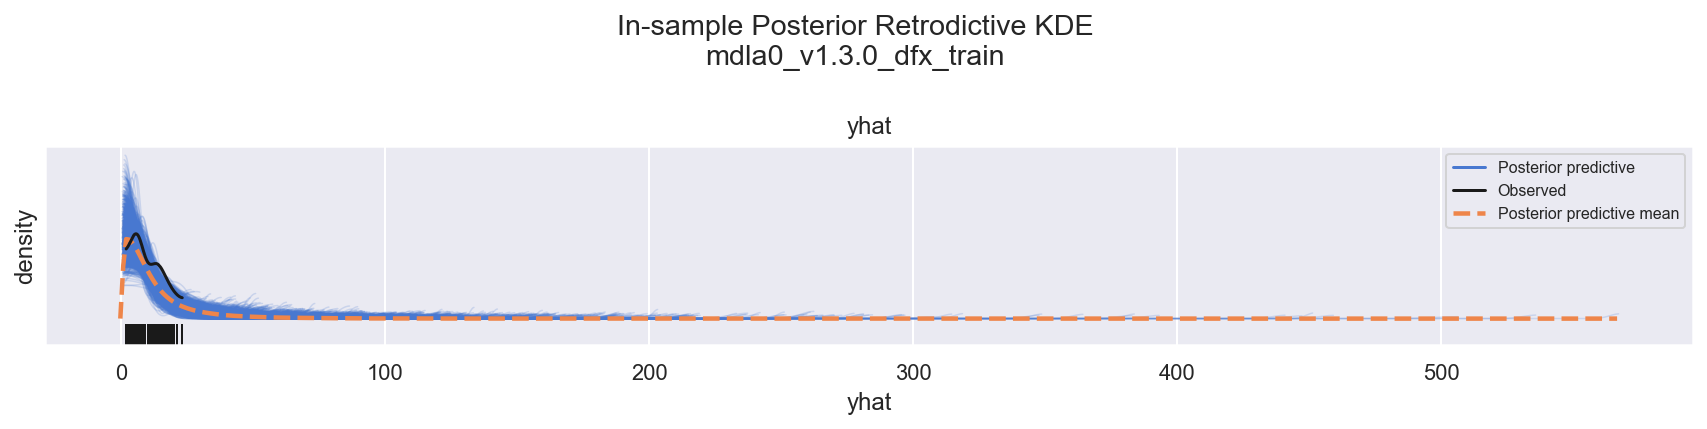

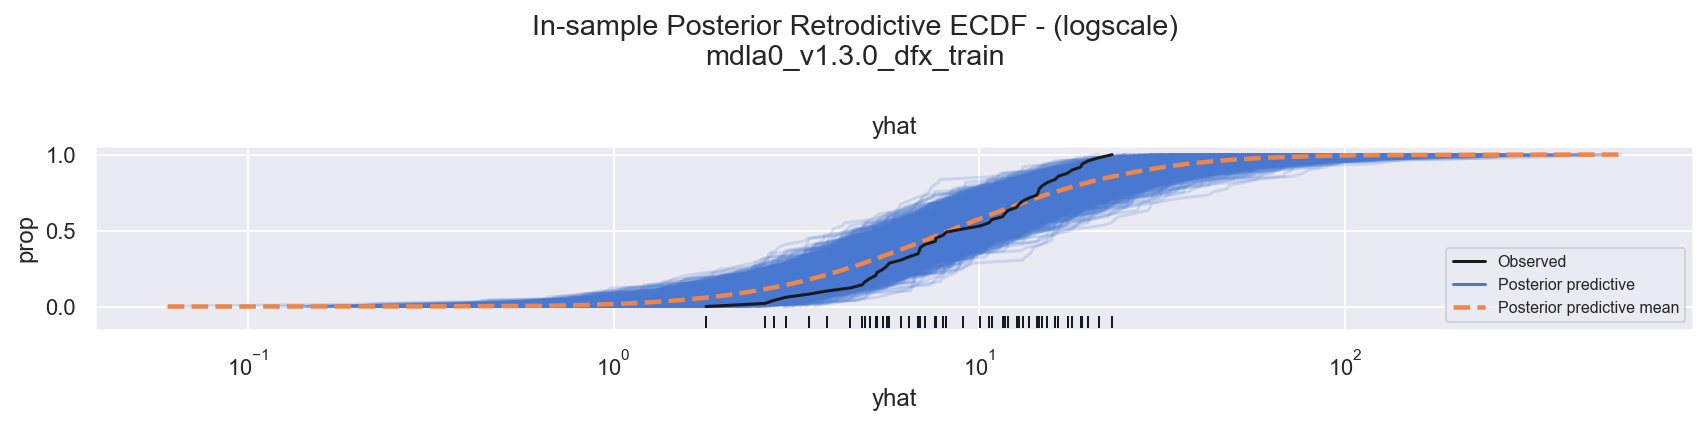

In [19]:
# post-process: copy y into observed as yhat so we can work with it / plot it etc
mdla0.idata.observed_data = mdla0.idata.observed_data.assign(yhat=deepcopy(mdla0.idata.constant_data.y))
f = mt.plot_ppc(mdl=mdla0, group=GRP, var_names=['yhat'], ecdf=False, observed_rug=True)
f = mt.plot_ppc(mdl=mdla0, group=GRP, var_names=['yhat'], logx=True, observed_rug=True)

**Observe:**

+ This is a better measure of model fit accounting for covariance: the bulk is okay, but the tails are very overdispersed

### 2.4.3 Additional In-Sample Evaluations, largely superseded by Retrodictive and LOO-PIT checks, but keep for future reference

#### 2.4.3.1 Coverage aka Calibration Plot of $\hat{y}$

This is another way to check model calibration:
+ It's more naive than the ECDF plot because it summarises the samples over credible regions (CR) rather than all samples
+ But it does yield a simple AUC measurement that can be helpful in some cases
+ Kept here mainly for posterity so we can return to use it another time if needed

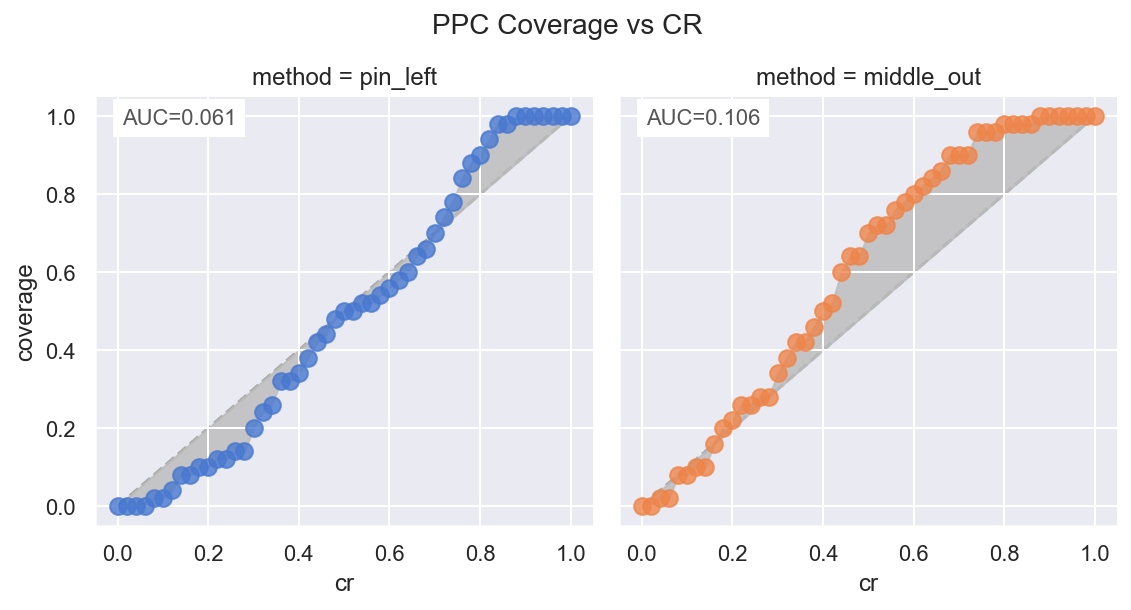

In [20]:
dfy = az.extract(mdla0.idata, group='constant_data', var_names=['y'], combined=False,).to_dataframe()
dfyhat = az.extract(mdla0.idata, group='posterior_predictive', var_names=['yhat']).to_dataframe().drop(['chain', 'draw'], axis=1)
df_cov_eloss = mt.calc_ppc_coverage(dfy['y'].values, dfyhat.unstack(0).T.values)
f = eda.plot_coverage(df_cov_eloss)


**Observe:**

+ The `pin_left` method is more appropriate for this positive-only distribution `yhat`
+ The $\text{AUC} \approx 0.06$ isn't terrible (it can be nearly 10x as large at $0.5$), but like the EDCF plot shows room for improvement in the 
  bulk and the tails too

### 2.4.3.2: Plot RMSE and $R^{2}$

These are another way to check model calibration:

+ The `RMSE` calc summarises the samples, but does show where the "sweet spot" of the PPC sits, and can be a useful 
  metric to quote in later comparisons, esp with Frequentist models
+ The `Bayesian R2` calc actually uses all the samples and is an up-to-date method
+ Both are kept here mainly for posterity so we can return to use it another time if needed

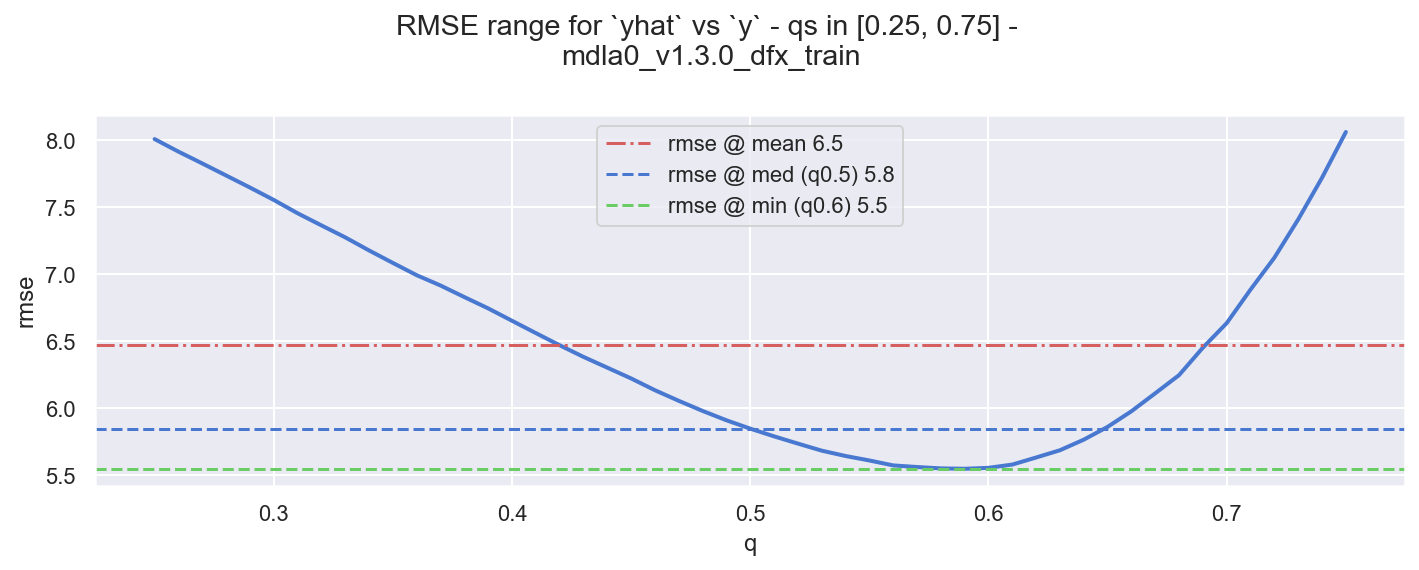

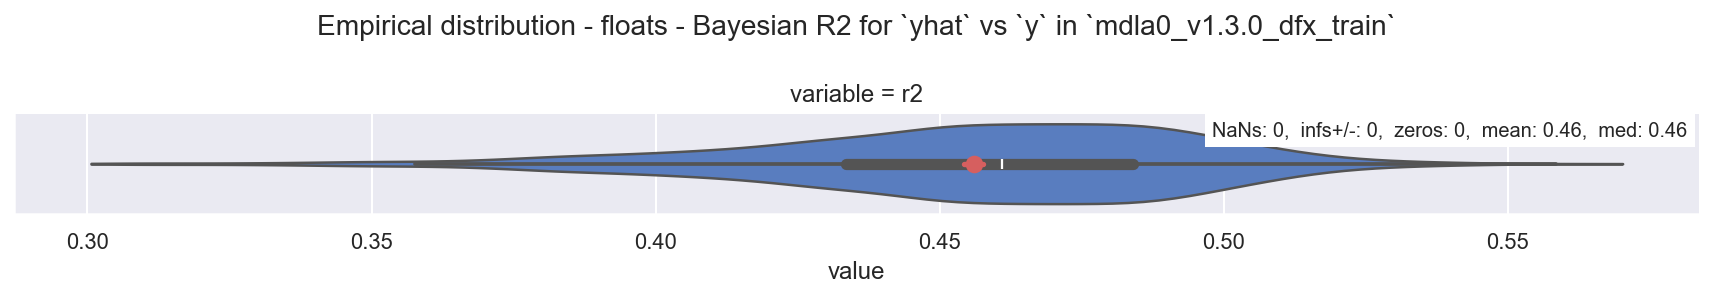

In [21]:
dfyhaty = pd.merge(dfyhat.reset_index(), dfy.reset_index(), how='left', on='oid').set_index(['oid', 'chain', 'draw'])
rmse, rmse_qs = mt.calc_rmse(dfyhaty, oid='oid', yhat='yhat', y='y', method='a', qs=True)
_ = eda.plot_rmse_range(rmse, rmse_qs.loc[0.25:0.75], yhat='yhat', y='y', txtadd=f'\n{mdla0.mdl_id}')

df_r2 = mt.calc_bayesian_r2(dfy['y'].values, dfyhat.unstack(0).T.values)
f = eda.plot_float_dist(df_r2, ['r2'], log=False, txtadd=f'Bayesian R2 for `yhat` vs `y` in `{mdla0.mdl_id}`')

**Observe:**

+ The `RMSE` distribution has quite a narrow minimum (high variance)
+ The `Bayesian R^2` isn't terrible, but indicates a large fraction of unexplained variance, and itself is defined with high variance

### 2.4.4 Jointplots of PPC marginals - another method to intuit PPC covariance

#### Mean

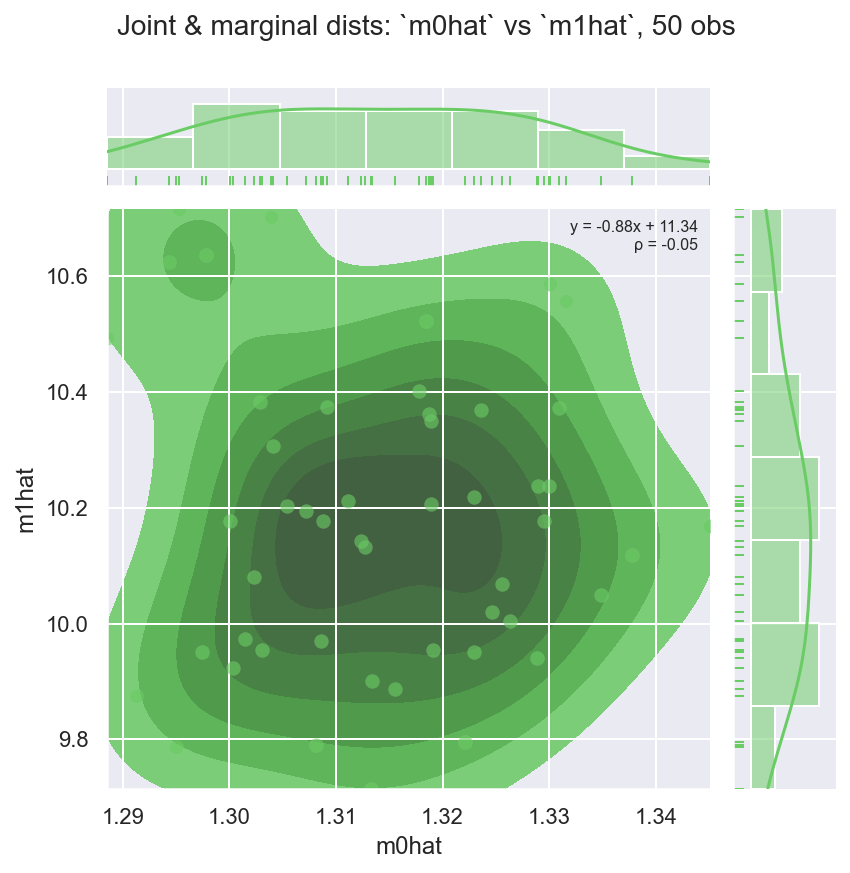

In [22]:
rv = 'mhat'
cols = mdla0.coords[f'{rv}_nm']
mhat = az.extract(mdla0.idata, group='posterior_predictive', var_names=rv).values
dfp = pd.DataFrame(np.nanmean(mhat, axis=2), columns=cols)
f = eda.plot_joint_numeric(data=dfp, ft0=cols[0], ft1=cols[1], kind='kde+scatter', 
            colori=2, subtitle='In-Sample Posterior Predictive Marginals (mean)')

**Observe:**

+ Note the near-zero correlation $\rho \approx 0$, which doesn't map to our observed data

> This is a plot of the sample mean, so we might not expect to see tails here, instead we will look at the quantiles

#### Quantiles

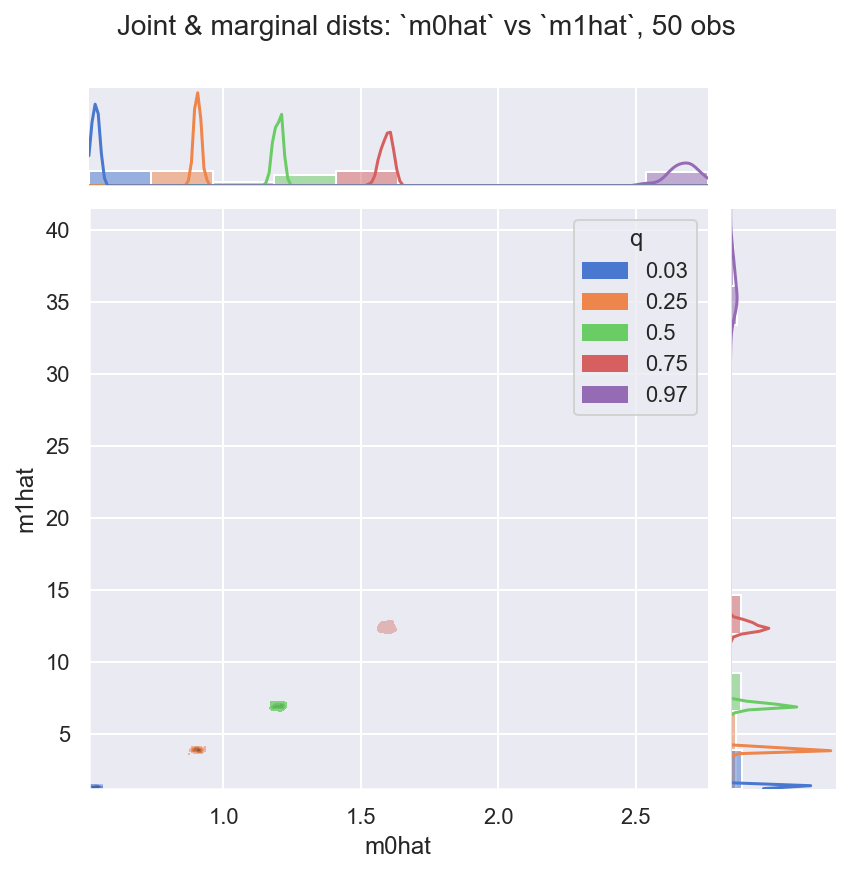

In [23]:
qs = [0.03, 0.25, 0.5, 0.75, 0.97]
dfp = pd.DataFrame(np.quantile(mhat, qs, axis=2).reshape(len(qs)*mdla0.n, 2), columns=cols)
dfp['q'] = np.repeat([f'{q}'  for q in qs], mdla0.n)
f = eda.plot_joint_numeric(data=dfp, ft0=cols[0], ft1=cols[1], hue='q', kind='kde', # legendpos='lower right',
            subtitle='In-Sample Posterior Predictive Marginals (quantiles)')

**Observe**

+ The PPC quantile range covers the range of the observed data quite well, although within each quantile we still see the lack of covariance

> So the marginals fit well, but (as expected) the covariance in the data seems to not have been captured by the model

---

## 2.5 Evaluate LOO-PIT (In-Sample)

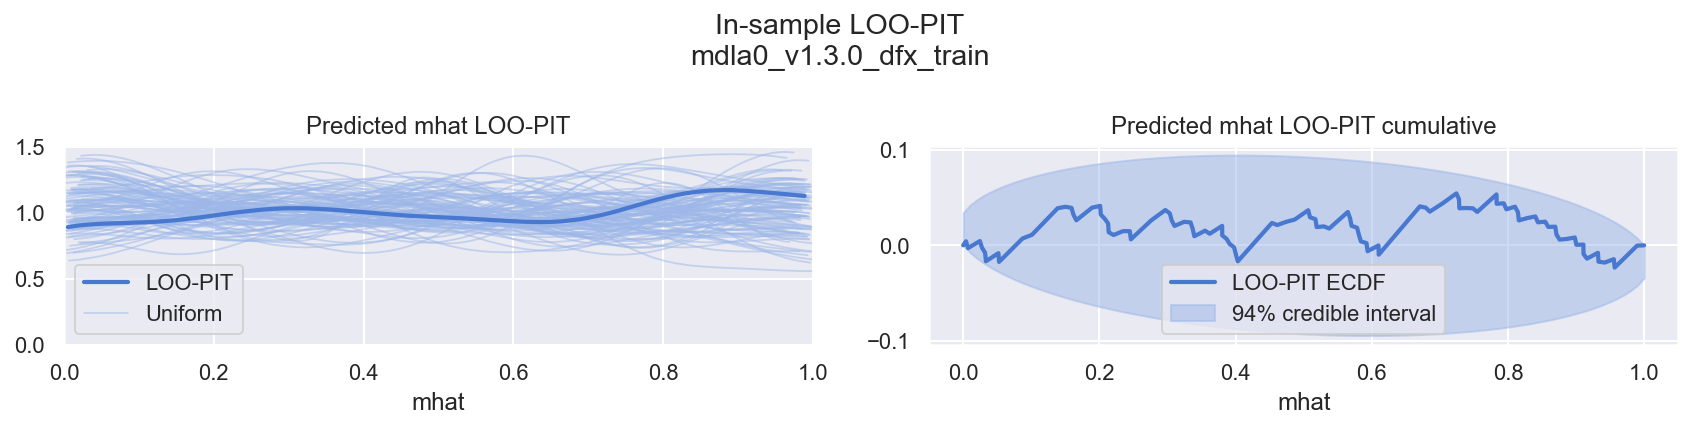

In [24]:
f = mt.plot_loo_pit(mdla0, data_pairs={'mhat': 'mhat'})

**Observe**

+ Seems like a good fit based on the marginals `mhat`
+ Again we note this doesn't reflect the latent covariance structure in the observed data

---

## 2.6 ~~Compare Log-Likelihood vs other models~~

NOTE:

+ Nothing to compare with yet

---

## 2.7 Evaluate Fitted Posterior Parameters

NOTE: Because this is a synthetic dataset, we can evaluate parameter recovery

### 2.7.1 Evaluate hyperpriors on linear submodels

#### 2.7.1.1 Univariate

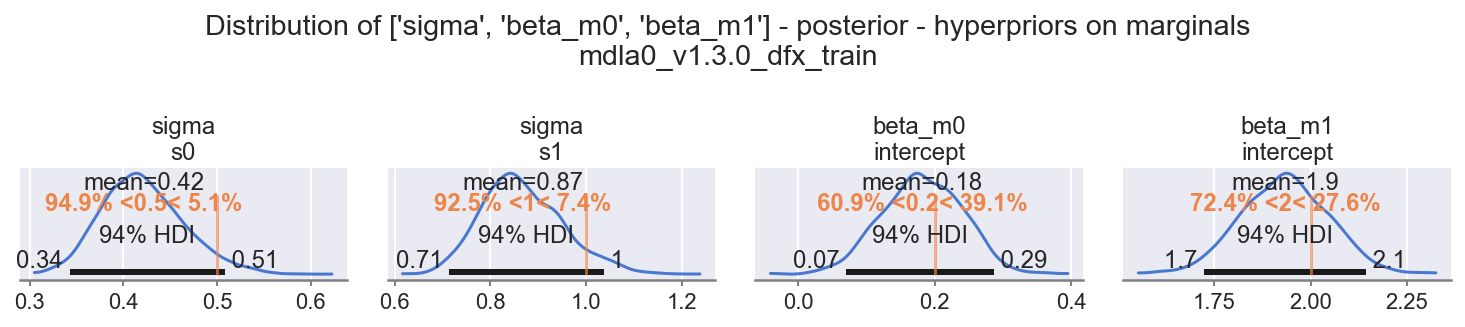

In [25]:
# get ref values from copula builder
refs = [cb.ref_vals['m0_params']['sigma'], cb.ref_vals['m1_params']['sigma'],
        cb.ref_vals['m0_params']['mu'], cb.ref_vals['m1_params']['mu']]
f = mt.facetplot_krushke(mdl=mdla0, group=GRP, txtadd='hyperpriors on marginals',
        rvs=mdla0.rvs_marg, ref_vals=refs, m=4, rvs_hack=1)

**Observe:**

+ `sigma: S0`: $\mathbb{E} \approx 0.4$: a little lower and narrower than prior. $\text{HDI}_{94} \ni \text{refval}$
+ `sigma: S1`: $\mathbb{E} \approx 0.9$: narrower than prior, but same location. $\text{HDI}_{94} \ni \text{refval}$
+ `beta_m0: intercept`: $\mathbb{E} \approx 0.2, \text{HDI}_{94} \not\ni 0$: slightly positive, substantial effect. $\text{HDI}_{94} \ni \text{refval}$
+ `beta_m1: intercept`: $\mathbb{E} \approx 1.9, \text{HDI}_{94} \not\ni 0$: more positive, substantial effect. $\text{HDI}_{94} \ni \text{refval}$.
+ Parameter recovery looks good for all.

#### 2.7.1.2 Bivariate - looking for correlations

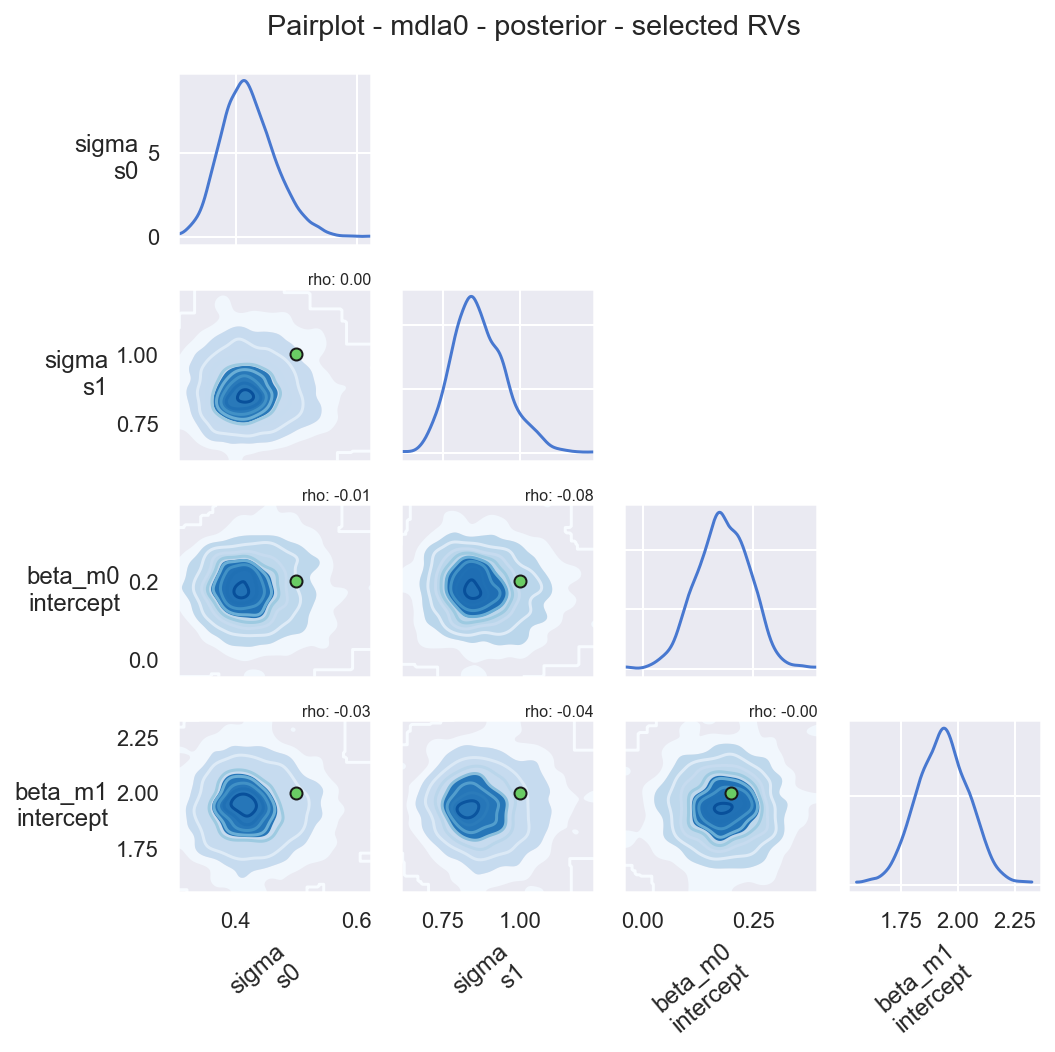

In [26]:
refsd = {'sigma\ns0': cb.ref_vals['m0_params']['sigma'], 'sigma\ns1' :cb.ref_vals['m1_params']['sigma'],
        'beta_m0\nintercept': cb.ref_vals['m0_params']['mu'], 'beta_m1\nintercept': cb.ref_vals['m1_params']['mu']}
f = mt.pairplot_corr(mdl=mdla0, rvs=mdla0.rvs_marg, ref_vals=refsd)

**Observe:**

+ This is another view of the parameter recovery for marginal linear submodel parameters - which seems good for all.
+ Note lack of correlation between `beta_m0` and `beta_m1` because they're not correlated in the model

### ~~2.7.2 Copula Structure~~

Placeholder section unused, because this model doesn't use a copula!

In [27]:
# None

---

## 2.8 Forecast $\hat{y}$ on Out-of-Sample Holdout Set

**Discussion**

 
Strictly speaking, our Bayesian modeling workflow does not require us to evaluate the model on an **out-of-sample** 
Holdout (aka Test) dataset because we use in-sample Pareto-smoothed Leave-One-Out (LOO-PIT) cross-validation testing 
shown above. The LOO-PIT method is more powerful and lets us fit & evaluate the model using the full Working set

However, because this model is parametric, we _can_ make a **forecast** $\hat{y} = \hat{M_{0}} \cdot \hat{M_{1}}$ for new datapoints in an **out-of-sample dataset**. 
 
Furthermore here specifically, we use the `holdout` dataset defined above an out-of-sample dataset, where we also know
the true value, so we can directly compare to the predictions for the sake of further understanding the model behaviour

### 2.8.1 Sample PPC on `holdout` set

In [28]:
mdla0.replace_obs(obsd={'obs_m0':dfx_m0_holdout, 'obs_m1':dfx_m1_holdout}, obs_nm='dfx_holdout')
mdla0.build()
f_idata = mdla0.sample_posterior_predictive(store_ppc=False, insamp=False, var_names=mdla0.rvs_ppc + mdla0.rvs_det)
f_idata

Output()

Inference data with groups:
	> predictions
	> predictions_constant_data

### 2.8.2 View PPC on marginal distributions $M_{0}$, $M_{1}$ on individual observations $i$

Let's view the marginals and their correlation (or lack thereof in this simple no-copula model)

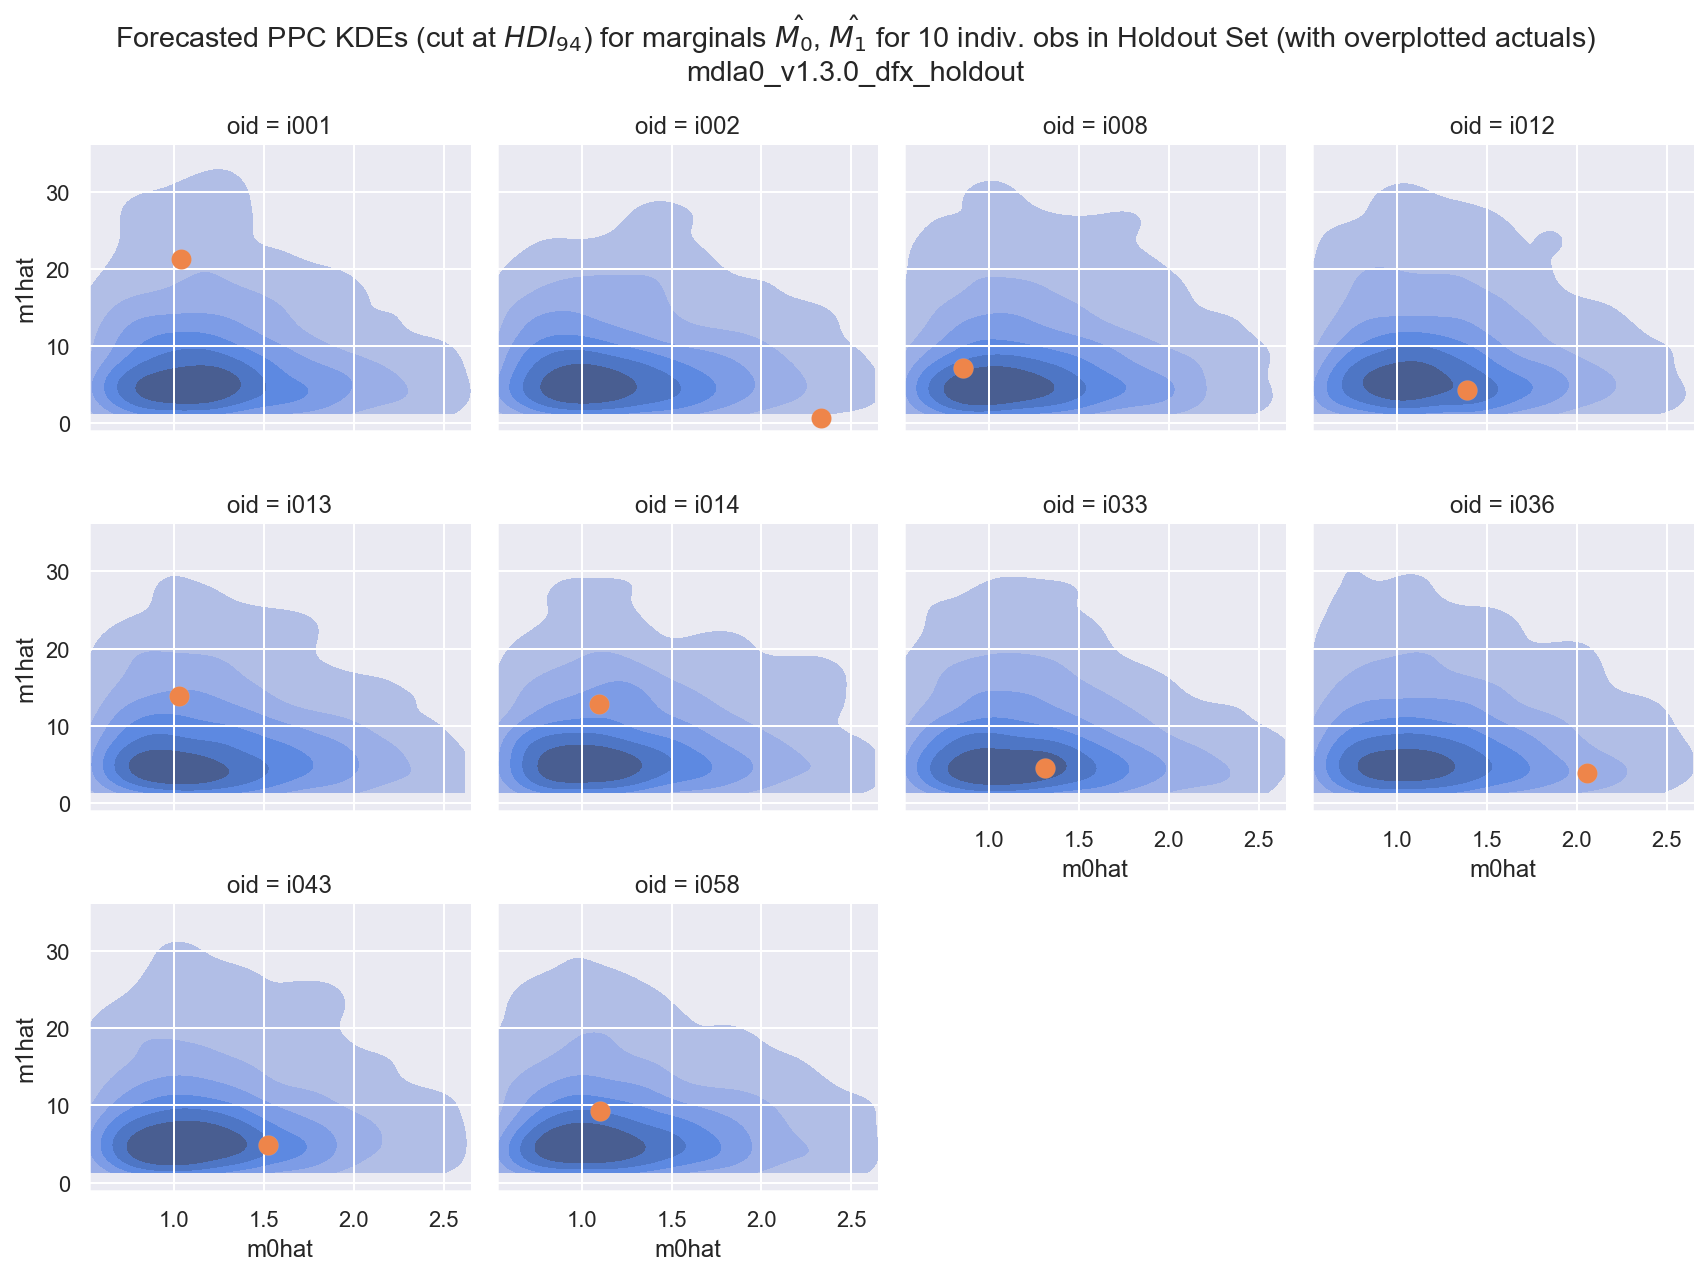

In [29]:
dfp = az.extract(f_idata, group='predictions', var_names=['mhat']).to_dataframe().drop(['chain', 'draw'], axis=1).unstack(1)
dfp.columns = dfp.columns.droplevel(0)

idx_m0 = (dfp['m0hat'] >= dfp['m0hat'].quantile(0.03)) & (dfp['m0hat'] <= dfp['m0hat'].quantile(0.97))
idx_m1 = (dfp['m1hat'] >= dfp['m1hat'].quantile(0.03)) & (dfp['m1hat'] <= dfp['m1hat'].quantile(0.97))

kde_kws = dict(zorder=0, levels=7, cut=0, fill=True, legend=True, warn_singular=False)
scatter_kws = dict(alpha=1, marker="o", linewidths=0.05, edgecolor="#dddddd", s=100, c='C1', zorder=2)
g = sns.displot(x='m0hat', y='m1hat', col='oid', col_wrap=4, data=dfp.loc[idx_m0 & idx_m1], kind='kde', height=3, aspect=1, **kde_kws)
_ = g.fig.suptitle(f'Forecasted PPC KDEs (cut at $HDI_{{94}}$) for marginals $\\hat{{M_{0}}}$, $\\hat{{M_{1}}}$ '+
                    f'for {mdla0.n} indiv. obs in Holdout Set (with overplotted actuals)'+ f'\n{mdla0.mdl_id}')
_ = [sns.scatterplot(x='m0', y='m1', data=df_holdout.iloc[[i]], ax=ax, **scatter_kws) for i, ax in enumerate(g.axes)]
_ = g.fig.tight_layout()
_ = figio.write(g.fig, fn=f'100_2.8.2_ppc_holdout_marginals_{mdla0.mdl_id}')


**Observe:**

+ Each subplot is the predicted joint distribution $(\hat{M_{0}}, \hat{M_{1}})$ for an individual observation `oid` in 
  the Holdout set `df_holdout`, shown as a KDE in blue shades
  + The KDE is almost the same on each subplot because this model doesn't regress onto individual features of the 
    observations $\mathbf{x}_{i}$ (slight differences are due to natural variation in the sampling)
  + Note the KDEs don't display a particularly strong correlation
+ Because this is a holdout set where we know the True value, we overplot it $(m_{0}, m_{1})$ to compare (orange markers)
  + We see the True point value is captured by the predicted KDE (cut at $HDI_{94}$) in all cases: good
  + Note this kind of introspection / evaluation vs actual values is of course wildly impractical for larger holdout sets

### 2.8.3 View PPC on resultant combined distribution $\hat{y}_{i}$ on individual observations

Let's view the resulting $\hat{y}_{i} = \hat{M_{0}} \cdot \hat{M_{1}}$ for individuals

In [30]:
dfp = az.extract(f_idata, group='predictions', var_names=['yhat']).to_dataframe().drop(['chain', 'draw'], axis=1).reset_index()
df_holdout['y'] = df_holdout['m0'] * df_holdout['m1']

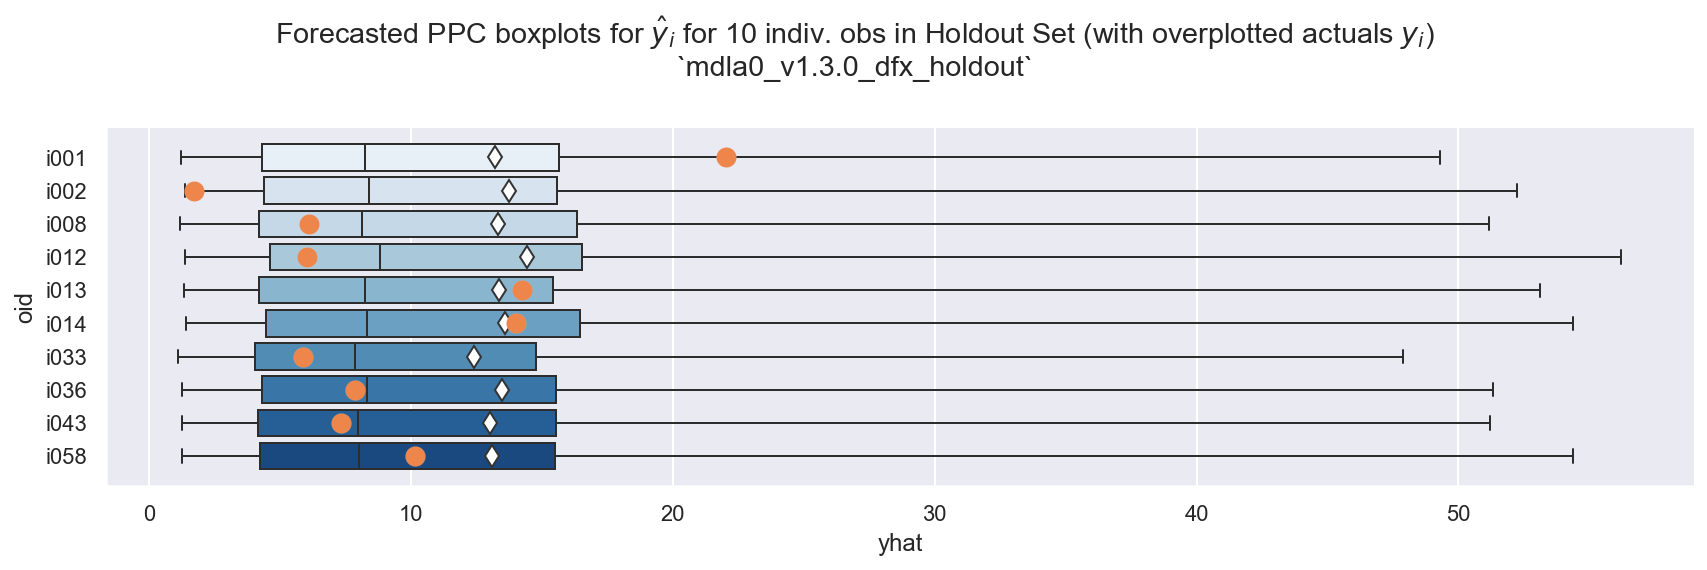

In [31]:
mn_pt_kws=dict(markerfacecolor='w', markeredgecolor='#333333', marker='d', markersize=8)
box_kws=dict(kind='box', showfliers=False, orient='h', showmeans=True, whis=(3, 97), meanprops=mn_pt_kws)

g = sns.catplot(x='yhat', y='oid', data=dfp, **box_kws, height=4, aspect=3, palette='Blues', zorder=1)
_ = sns.scatterplot(x='y', y='oid', data=df_holdout.reset_index(), ax=g.axes.flatten()[0], **scatter_kws)
_ = g.fig.suptitle('Forecasted PPC boxplots for $\\hat{y}_{i}$ '
                + f'for {mdla0.n} indiv. obs in Holdout Set (with overplotted actuals $y_{{i}}$)\n`{mdla0.mdl_id}`')
_ = g.fig.tight_layout()
_ = figio.write(g.fig, fn=f'100_2.8.3_ppc_holdout_y_{mdla0.mdl_id}')

**Observe:**

+ Each bar is the predicted resultant distribution $\hat{y}$ for an individual observation `oid` in the Holdout set `df_holdout`
  + The bars are almost the same on each subplot because this model doesn't regress onto individual features of the 
    observations $\mathbf{x}_{i}$ (slight differences are due to natural variation in the sampling)
  + We see even more clearly that variations in the Actual observations are not captured by the model, but the overall 
    behaviour looks reasonable
+ Because this is a holdout set where we know the True value, we overplot it $(m_{0}, m_{1})$ to compare (orange markers)
  + We see the True point value is captured by the predicted KDE (cut at $HDI_{94}$) in all cases: good
  + Note this kind of introspection / evaluation vs actual values is of course wildly impractical for larger holdout sets

### 2.8.4 View PPC on mean resultant combined distribution $\overline{\hat{y}}$ on entire Holdout set

NOTE:

+ Let's view the resulting mean estimate $\overline{\hat{y}}$ for the entire Holdout set. In practice, this could 
  represent a mean Estimated Expected Loss Cost $\mathbb{E}_{\text{loss}}$ for a portfolio, and is critical to get right.
+ We view the distribution as a simple boxplot and an Exceedance curve (1-ECDF) to demonstrate the different ways we 
  can interpret the same data and form quantified decisions
+ In each case we overplot the equivalent Actual value $\overline{y}$ for comparision, itself a bootstrap resample 
  to give a fair representation of the natural variance in the data.

#### Boxplot Empirical PDF

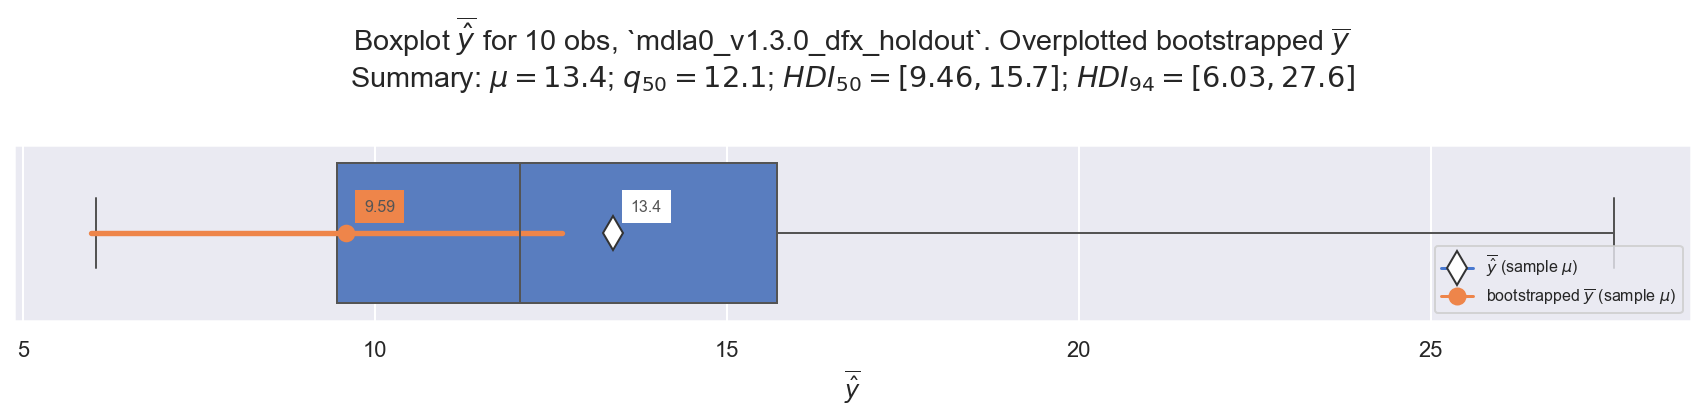

In [32]:
f = eda.plot_estimate(yhat=dfp.groupby(['chain', 'draw'])['yhat'].mean().values, nobs=len(df_holdout),
                      yhat_nm='$\\overline{\\hat{y}}$', txtadd=f'`{mdla0.mdl_id}`',
                      y=eda.bootstrap(a=df_holdout['y'].values, summary_fn=np.mean),
                      y_nm='bootstrapped $\\overline{y}$')
_ = figio.write(f, fn=f'100_2.8.4_ppc_holdout_y_boxplot_{mdla0.mdl_id}')

**Observe:**

+ Now we can clearly see the impact: although the in-sample model fit was acceptable, the combined value $y$ is way
  off, because this model ignores copula correlation between the marginals
+ The mean of $\overline{\hat{y}}$ is $\mu \approx 13.4$, is very different (and sits outside of) the bootstrapped actual data $\overline{\hat{y}}$ is $\mu \approx 9.6$
+ Comparing means we have a $\frac{13.4}{9.6} \approx +40\%$ overestimate!
+ We do see that the PPC distribution envelops the bootstrapped actual data, which is promising, and means the model 
  wouldn't necessarily be wrong to use, but there is clearly room to improve!

#### Exceedence Curve (1 - ECDF)

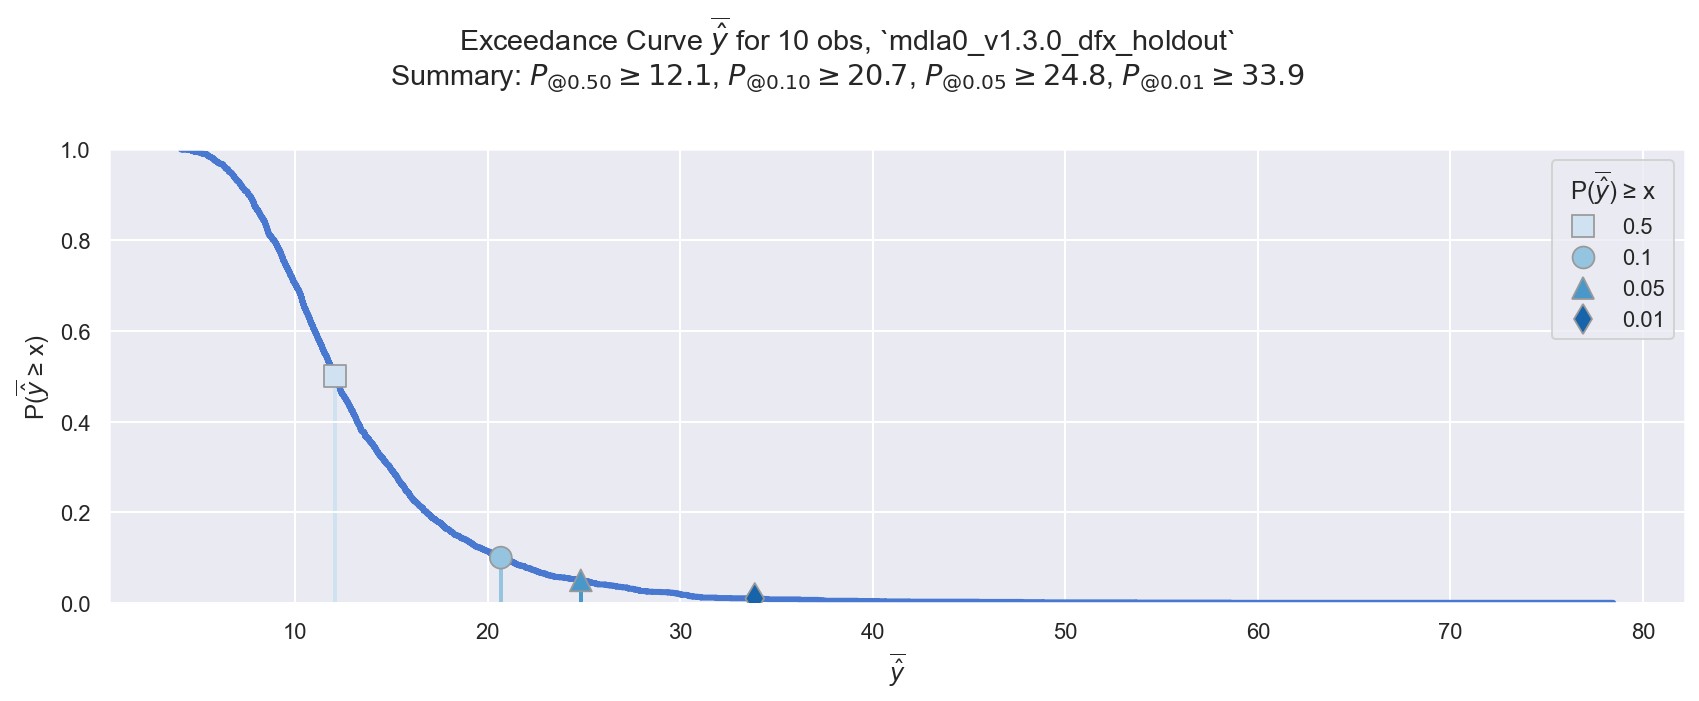

In [33]:
f = eda.plot_estimate(yhat=dfp.groupby(['chain', 'draw'])['yhat'].mean().values, nobs=len(df_holdout),
                      yhat_nm='$\\overline{\\hat{y}}$', txtadd=f'`{mdla0.mdl_id}`', exceedance=True)
_ = figio.write(f, fn=f'100_2.8.4_ppc_holdout_y_exceedance_{mdla0.mdl_id}')

**Observe:**

Now we get to use the full power of the quantified uncertainty:
+ We can read this curve _horizontally_ to determine the value $y$ at a particular probability
+ We can read this curve _vertically_ to determine the empirical probability of achieving a particular value $y$

e.g. Read horizontally:

+ $P_{@0.50}\ \overline{\hat{y}} \geq 12.1$, (aka $\overline{\hat{y}} \approx 12.1$ @ 1-in-2), lower than the (right-skewed) mean we see above
+ $P_{@0.05}\ \overline{\hat{y}} \geq 24.8$, (aka $\overline{\hat{y}} \approx 24.8$ @ 1-in-20)

e.g. Read vertically:
+ $P(\overline{\hat{y}} > 20) \approx 0.1$: i.e. if we're worried about $\overline{\hat{y}} > 20$, we might be mildly concerned 
  because the probability is approx 1-in-10
+ $P(\overline{\hat{y}} > 30) \approx 0.01$: i.e. if we're worried about $\overline{\hat{y}} > 30$, we might be less concerned 
  because the probability is approx 1-in-100

+ This is a broad distribution with heavy tails and unlikely to be very robust / useful

> After all this evaluation, we move to the next model in the series in the next notebook

---

---

# Notes

In [34]:
# Sanity-check Lognorm Implementations `scipy` vs `pymc`
mt.sanity_check_lognorm(cb.ref_vals['m0_params']['mu'], cb.ref_vals['m1_params']['sigma'])

In [35]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv -p pymc,pytensor

Author: jonathan.sedar@oreum.io

Last updated: 2025-02-06 18:38:59

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.32.0

pymc    : 5.20.0
pytensor: 2.26.4

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

arviz     : 0.20.0
oreum_core: 0.10.1
pyprojroot: 0.3.0
seaborn   : 0.13.2
sys       : 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:19:53) [Clang 18.1.8 ]
numpy     : 1.26.4
pandas    : 2.2.3



---
**Oreum Industries &copy; 2024**